<a href="https://colab.research.google.com/github/Adiactive/Ensemble-Methods/blob/main/Ensemble%20Methods%20Implementation%20and%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ENSEMBLE METHODS
The idea is to construct a set of classifiers that is used to classify a new data point by the weighted or unweighted average of their predictions.In order for an ensemble to outperform a single classifier it must be both accurate and diverse.

In [ ]:
#load libray
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10, cifar100

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

import numpy as np
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import resample
import matplotlib.pyplot as plt
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

# Load dataset:mnist

In [ ]:
#load mnist and split it into test set and train set
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
#x_train, x_test = x_train / 255.0, x_test_original / 255.0
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step


# Fast gradient sign method attack(FGSM)


In [ ]:
#create perturbations which will be used to distort the original image resulting in an adversarial image.
def adversarial_pattern(image, label,model):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [ ]:
#function used to create FGSM attack for a single neural network
def adversarial_attack(model,image_set,label_set,eps=0.1):
  res=np.array(image_set, copy=True)  
  i=0
  for image,image_label in zip(image_set,label_set):
    perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label,model).numpy()
    adversarial = image + perturbations * eps
    res[i]=adversarial
    i+=1
  return res

In [ ]:
#function used to generate FGSM attack based on the average gradient of a group of neural networks
def adversarial_attack_modelSet(model_Set,image_set,label_set):
  res=np.array(image_set, copy=True)  
  i=0
  for image,image_label in zip(image_set,label_set):
    pert = 0
    for model in model_Set:
      perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label,model).numpy()
      pert += perturbations
    adversarial = image + pert * 0.1 /len(model_Set)
    res[i]=adversarial
    i+=1
  return res

#Define different structure neural networks and use FGSM to test their robustness

FGSM attack with same value of epsilon has different effect on different structure neural network. Some neural network's accuracy decreased less than others, which mean some neural network is more robust.

##Structure 1

In [ ]:
#create structure of model
#structure 1
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu',kernel_initializer='random_normal',bias_initializer='zeros', input_shape=(img_rows, img_cols, channels)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu',kernel_initializer='random_normal',bias_initializer='zeros',))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu',kernel_initializer='random_normal',bias_initializer='zeros',))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32,kernel_initializer='random_normal',bias_initializer='zeros',))
    model.add(Dropout(0.2))
    model.add(Dense(32,kernel_initializer='random_normal',bias_initializer='zeros',))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax',kernel_initializer='random_normal',bias_initializer='zeros',))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
s1,s2,s3=[],[],[]
s1_a,s2_a,s3_a=[],[],[]
times=1

In [ ]:

#create model and fit data
for i in range(times):
  model1 = create_model()
  model1.fit(x_train, y_train,
            batch_size=32,
            epochs=10,
            validation_data=(x_test, y_test))
  res=model1.evaluate(x=x_test, y=y_test, verbose=0)
  print("Base accuracy of the model1 on regular images without FGSM attack:", res[1])
  s1_base=res[1]
  s1.append(s1_base)
  ad_attack1 = adversarial_attack(model1,x_test,y_test)
  s1_attack=model1.evaluate(x=ad_attack1, y=y_test, verbose=0)[1]
  print("Base accuracy on regular images with FGSM attack", s1_attack) 
  s1_a.append(s1_attack)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0258 - accuracy: 0.8139 - val_loss: 0.0084 - val_accuracy: 0.9453
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0109 - accuracy: 0.9291 - val_loss: 0.0056 - val_accuracy: 0.9630
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0085 - accuracy: 0.9450 - val_loss: 0.0054 - val_accuracy: 0.9637
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0073 - accuracy: 0.9536 - val_loss: 0.0047 - val_accuracy: 0.9690
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0066 - accuracy: 0.9584 - val_loss: 0.0043 - val_accuracy: 0.9705
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0062 - accuracy: 0.9603 - val_loss: 0.0043 - val_accuracy: 0.9723
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0057 - accuracy: 0.9632 - val_loss: 0.0037 - val_accuracy:

In [ ]:
#try different values of epsilon
epsilons = [0, 0.01, 0.1, 0.15]
for eps in epsilons:
  ad_attack = adversarial_attack(model1,x_test,y_test,eps)
  print("Base accuracy on regular images with FGSM attack and eps=",eps,",", model1.evaluate(x=ad_attack, y=y_test, verbose=0)[1]) 

Base accuracy on regular images with FGSM attack and eps= 0 , 0.9782999753952026
Base accuracy on regular images with FGSM attack and eps= 0.01 , 0.9623000025749207
Base accuracy on regular images with FGSM attack and eps= 0.1 , 0.42590001225471497
Base accuracy on regular images with FGSM attack and eps= 0.15 , 0.1370999962091446


#Naive defence: adverserial training

In [ ]:
print(ad_attack1.shape,x_train.shape)
print(y_test.shape,y_train.shape)
combined_x_dataset = np.concatenate((ad_attack1,x_train), axis=0)
combined_y_dataset = np.concatenate((y_test,y_train), axis=0)
print(combined_x_dataset.shape)
print(combined_y_dataset.shape)

(10000, 28, 28, 1) (60000, 28, 28, 1)
(10000, 10) (60000, 10)
(70000, 28, 28, 1)
(70000, 10)


In [ ]:
model1_adv_train = create_model()
model1_adv_train.fit(combined_x_dataset, combined_y_dataset,
          batch_size=32,
          epochs=10)
res=model1_adv_train.evaluate(x=x_test, y=y_test, verbose=0)
print("Base accuracy of the adverserial trained model1 on regular images without FGSM attack:", res[1])
ad_attack_dataset = adversarial_attack(model1_adv_train,x_test,y_test)
res2=model1_adv_train.evaluate(x=ad_attack_dataset, y=y_test, verbose=0)[1]
print("Base accuracy of the adverserial trained model1 on regular images with FGSM attack", res2) 


Epoch 1/10
2188/2188 [==============================] - 6s 3ms/step - loss: 0.0235 - accuracy: 0.8323
Epoch 2/10
2188/2188 [==============================] - 6s 3ms/step - loss: 0.0100 - accuracy: 0.9353
Epoch 3/10
2188/2188 [==============================] - 6s 3ms/step - loss: 0.0080 - accuracy: 0.9482
Epoch 4/10
2188/2188 [==============================] - 6s 3ms/step - loss: 0.0070 - accuracy: 0.9555
Epoch 5/10
2188/2188 [==============================] - 6s 3ms/step - loss: 0.0061 - accuracy: 0.9608
Epoch 6/10
2188/2188 [==============================] - 6s 3ms/step - loss: 0.0057 - accuracy: 0.9632
Epoch 7/10
2188/2188 [==============================] - 6s 3ms/step - loss: 0.0052 - accuracy: 0.9667
Epoch 8/10
2188/2188 [==============================] - 6s 3ms/step - loss: 0.0048 - accuracy: 0.9697
Epoch 9/10
2188/2188 [==============================] - 6s 3ms/step - loss: 0.0046 - accuracy: 0.9710
Epoch 10/10
2188/2188 [==============================] - 7s 3ms/step - loss: 0.004

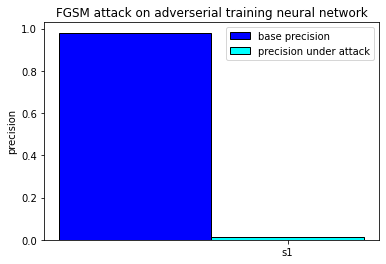

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
# width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars
bars1 = [res[1]]
 
# Choose the height of the cyan bars
bars2 = [res2]
 

 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black' ,capsize=7, label='base precision')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black' ,capsize=7, label='precision under attack')
 
# general layout
plt.title('FGSM attack on adverserial training neural network')
plt.xticks([r + barWidth for r in range(len(bars1))], ['s1'])
plt.ylabel('precision')
plt.legend()

As the value of epsilon is increased, it becomes easier to fool the network. Bur the perturbations becomes more identifiable.

##Structure 2

In [ ]:
#structure 2
def create_model2():
    model = Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
      tf.keras.layers.Dense(128,activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

In [ ]:
for i in range(times):
  #create model and fit data
  model2 = create_model2()
  model2.fit(x_train, y_train,
            batch_size=32,
            epochs=10,
            validation_data=(x_test, y_test))
  s2_base=model2.evaluate(x=x_test, y=y_test, verbose=0)[1]
  print("Base accuracy of the model2 on regular images without FGSM attack:", s2_base)
  ad_attack2 = adversarial_attack(model2,x_test,y_test)
  s2_attack=model2.evaluate(x=ad_attack2, y=y_test, verbose=0)[1]
  print("Base accuracy of the model2 on regular images with FGSM attack", s2_attack) 
  s2.append(s2_base)
  s2_a.append(s2_attack)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0119 - accuracy: 0.9233 - val_loss: 0.0069 - val_accuracy: 0.9560
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0058 - accuracy: 0.9633 - val_loss: 0.0052 - val_accuracy: 0.9663
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0042 - accuracy: 0.9736 - val_loss: 0.0043 - val_accuracy: 0.9717
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0033 - accuracy: 0.9793 - val_loss: 0.0040 - val_accuracy: 0.9748
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0027 - accuracy: 0.9837 - val_loss: 0.0041 - val_accuracy: 0.9733
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0023 - accuracy: 0.9860 - val_loss: 0.0033 - val_accuracy: 0.9787
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0019 - accuracy: 0.9880 - val_loss: 0.0032 - val_accuracy:

## structure3

In [ ]:
#structure 3
def create_model3():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
for i in range(times):
  #create model and fit data
  model3 = create_model3()
  model3.fit(x_train, y_train,
            batch_size=32,
            epochs=10,
            validation_data=(x_test, y_test))
  s3_base = model3.evaluate(x=x_test, y=y_test, verbose=0)[1]
  print("Base accuracy of the model3 on regular images without FGSM attack:", s3_base)
  ad_attack3 = adversarial_attack(model3,x_test,y_test)
  s3_attack = model3.evaluate(x=ad_attack3, y=y_test, verbose=0)[1]
  print("Base accuracy of the model3 on regular images with FGSM attack", s3_attack) 
  s3.append(s3_base)
  s3_a.append(s3_attack)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1797 - accuracy: 0.9455 - val_loss: 0.0823 - val_accuracy: 0.9740
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0600 - accuracy: 0.9824 - val_loss: 0.0617 - val_accuracy: 0.9801
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0388 - accuracy: 0.9880 - val_loss: 0.0471 - val_accuracy: 0.9839
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0262 - accuracy: 0.9920 - val_loss: 0.0410 - val_accuracy: 0.9862
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0182 - accuracy: 0.9948 - val_loss: 0.0408 - val_accuracy: 0.9864
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0129 - accuracy: 0.9961 - val_loss: 0.0374 - val_accuracy: 0.9879
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0082 - accuracy: 0.9980 - val_loss: 0.0375 - val_accuracy:

#transferability of FGSM on different structure neural network
we try to use FGSM attack generated by structure 1 to attack structure 2 and 3.

In [ ]:
s1_at_s2=model2.evaluate(x=ad_attack1, y=y_test, verbose=0)[1]
print("apply the FGSM attack generated by loss function of s1 to s2", s1_at_s2) 
s1_at_s3=model3.evaluate(x=ad_attack1, y=y_test, verbose=0)[1]
print("apply the FGSM attack generated by loss function of s1 to s3", s1_at_s3) 

apply the FGSM attack generated by loss function of s1 to s2 0.9024999737739563
apply the FGSM attack generated by loss function of s1 to s3 0.9629999995231628


we try to use FGSM attack generated by structure 2 to attack structure 1 and 3.

In [ ]:
s2_at_s1=model1.evaluate(x=ad_attack2, y=y_test, verbose=0)[1]
print("apply the FGSM attack generated by loss function of s1 to s3", s2_at_s1) 
s2_at_s3=model3.evaluate(x=ad_attack2, y=y_test, verbose=0)[1]
print("apply the FGSM attack generated by loss function of s2 to s3", s2_at_s3) 

apply the FGSM attack generated by loss function of s1 to s3 0.9204000234603882
apply the FGSM attack generated by loss function of s2 to s3 0.9404000043869019


we try to use FGSM attack generated by structure 3 to attack structure 1 and 2.

In [ ]:
s3_at_s1=model1.evaluate(x=ad_attack3, y=y_test, verbose=0)[1]
print("apply the FGSM attack generated by loss function of s3 to s1",s3_at_s1 ) 
s3_at_s2=model2.evaluate(x=ad_attack3, y=y_test, verbose=0)[1]
print("apply the FGSM attack generated by loss function of s3 to s2", s3_at_s2) 

apply the FGSM attack generated by loss function of s3 to s1 0.9578999876976013
apply the FGSM attack generated by loss function of s3 to s2 0.9265000224113464


#Define the prediction and evaulation of the ensemble learning
we use majority vote to decide the prediction of ensemble learning

In [ ]:
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	# sum across ensemble members
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	result = np.argmax(summed, axis=1)
	return result

In [ ]:
def evaluate_n_members(members, n_members, testX, y_test):
	# select a subset of members
	testy=[]
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	for item in y_test:
		testy.append(item.argmax())
	# calculate accuracy
	return accuracy_score(testy, yhat)

#Define multiple classifiers with the same network architecture but with random initial weights

In [ ]:
times=1
m1_base=[]
m1_attack1=[]
m1_attack_all=[]

In [ ]:
# fit model on dataset
def fit_model(x_train, y_train):
  #trainy_enc = to_categorical(trainy)
  # define model
  model = create_model()
  # fit model
  model.fit(x_train, y_train,batch_size=32,epochs=10)
  return model

#ensemble learning with three same structure neural network
for i in range(times):
  n_members = 3
  ensemble_same_struct = [fit_model(x_train, y_train) for _ in range(n_members)]
  base=evaluate_n_members(ensemble_same_struct,3,x_test,y_test)
  ad_attack_one = adversarial_attack(ensemble_same_struct[0],x_test,y_test)
  p1 = evaluate_n_members(ensemble_same_struct,3,ad_attack_one,y_test)
  ad_attack_all = adversarial_attack_modelSet(ensemble_same_struct,x_test,y_test)
  p2 = evaluate_n_members(ensemble_same_struct,3,ad_attack_all,y_test)
  m1_base.append(base)
  m1_attack1.append(p1)
  m1_attack_all.append(p2)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0263 - accuracy: 0.8120
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0110 - accuracy: 0.9284
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0086 - accuracy: 0.9448
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0074 - accuracy: 0.9525
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0066 - accuracy: 0.9579
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0060 - accuracy: 0.9618
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0057 - accuracy: 0.9641
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0053 - accuracy: 0.9659
Epoch 9/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0050 - accuracy: 0.9685
Epoch 10/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.004

In [ ]:
print("precision of the ensemble learning based on three same structure neural networks ")
print("precision without FGSM attack:",evaluate_n_members(ensemble_same_struct,3,x_test,y_test))

precision of the ensemble learning based on three same structure neural networks 
precision without FGSM attack: 0.9833


In [ ]:
#gernerate FGSM attack based on the gradient of one neural network 
ad_attack_one = adversarial_attack(ensemble_same_struct[0],x_test,y_test)

In [ ]:
print("precision with FGSM attack from one neural network:",evaluate_n_members(ensemble_same_struct,3,ad_attack_one,y_test))

precision with FGSM attack from one neural network: 0.7066


In [ ]:
#gernerate FGSM attack based on the average of the gradients of all neural network
ad_attack_all = adversarial_attack_modelSet(ensemble_same_struct,x_test,y_test)

In [ ]:
print("precision with average FGSM attack from all neural network:",evaluate_n_members(ensemble_same_struct,3,ad_attack_all,y_test))

precision with average FGSM attack from all neural network: 0.7352


#multiple classifiers with different structure neural network architectures

In [ ]:
#different structure network
def ensemble_diff_struct():
  model1 = create_model()
  model1.fit(x_train, y_train,batch_size=32,epochs=10)
  model2 = create_model2()
  model2.fit(x_train, y_train,batch_size=32,epochs=10)
  model3 = create_model3()
  model3.fit(x_train, y_train,batch_size=32,epochs=10)
  return [model1,model2,model3]
m2_base,m2_attack1,m2_attack_all=[],[],[]
for i in range(times):
  ensemble_diff_structs = ensemble_diff_struct()
  base = evaluate_n_members(ensemble_diff_structs,3,x_test,y_test)
  ad_attack_one = adversarial_attack(ensemble_diff_structs[0],x_test,y_test)
  p1=evaluate_n_members(ensemble_diff_structs,3,ad_attack_one,y_test)
  ad_attack_all = adversarial_attack_modelSet(ensemble_diff_structs,x_test,y_test)
  p2=evaluate_n_members(ensemble_diff_structs,3,ad_attack_all,y_test)
  m2_base.append(base)
  m2_attack1.append(p1)
  m2_attack_all.append(p2)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0244 - accuracy: 0.8260
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0101 - accuracy: 0.9350
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0080 - accuracy: 0.9485
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0069 - accuracy: 0.9552
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0061 - accuracy: 0.9612
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0056 - accuracy: 0.9649
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0055 - accuracy: 0.9648
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0049 - accuracy: 0.9689
Epoch 9/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0049 - accuracy: 0.9693
Epoch 10/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.004

In [ ]:
print("precision of the ensemble learning based on three different structure neural networks ")
print("precision without FGSM attack:",evaluate_n_members(ensemble_diff_structs,3,x_test,y_test))

precision of the ensemble learning based on three different structure neural networks 
precision without FGSM attack: 0.989


In [ ]:
#gernerate FGSM attack based on the gradient of one neural network 
ad_attack_one = adversarial_attack(ensemble_diff_structs[0],x_test,y_test)

In [ ]:
print("precision with gradient attack from one neural network:",evaluate_n_members(ensemble_diff_structs,3,ad_attack_one,y_test))

precision with gradient attack from one neural network: 0.9103


In [ ]:
#gernerate FGSM attack based on the average of the gradients of all neural network
ad_attack_all = adversarial_attack_modelSet(ensemble_diff_structs,x_test,y_test)

In [ ]:
print("precision with average gradient attack from all neural network:",evaluate_n_members(ensemble_diff_structs,3,ad_attack_all,y_test))

precision with average gradient attack from all neural network: 0.7994


As for FGSM attack, multiple classifiers with different structure neural network architectures are more robust than that with same structure neural network

#Random Splits Ensemble 
We can use the train_test_split() function from the scikit-learn library to create a random split of a dataset into train and test sets. In that case, models within ensemble will fit different train set.

### same structure neural network

In [ ]:
m3_base,m3_attack1,m3_attack_all=[],[],[]
for i in range(times):
	n_members = 3
	ensemble_same_struct_random_split = []
	n_splits = 3
	scores, members = list(), list()
	for _ in range(n_splits):
		# split data
		trainX, testX, trainy, testy = train_test_split(x_train, y_train, test_size=0.20)
		# fit model
		model=fit_model(trainX, trainy)
		ensemble_same_struct_random_split.append(model)
	base=evaluate_n_members(ensemble_same_struct_random_split,3,x_test,y_test)
	ad_attack_one = adversarial_attack(ensemble_same_struct_random_split[0],x_test,y_test)
	p1=evaluate_n_members(ensemble_same_struct_random_split,3,ad_attack_one,y_test)
	ad_attack_all = adversarial_attack_modelSet(ensemble_same_struct_random_split,x_test,y_test)
	p2=evaluate_n_members(ensemble_same_struct_random_split,3,ad_attack_all,y_test)
	m3_base.append(base)
	m3_attack1.append(p1)
	m3_attack_all.append(p2)

Epoch 1/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0283 - accuracy: 0.7977
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0121 - accuracy: 0.9212
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0096 - accuracy: 0.9381
Epoch 4/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0085 - accuracy: 0.9452
Epoch 5/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0075 - accuracy: 0.9511
Epoch 6/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0068 - accuracy: 0.9565
Epoch 7/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0063 - accuracy: 0.9597
Epoch 8/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0060 - accuracy: 0.9611
Epoch 9/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0056 - accuracy: 0.9640
Epoch 10/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.005

In [ ]:
print("precision of the ensemble learning based on three same structure neural networks ")
print("precision without FGSM attack:",evaluate_n_members(ensemble_same_struct_random_split,3,x_test,y_test))

precision of the ensemble learning based on three same structure neural networks 
precision without FGSM attack: 0.9791


In [ ]:
#gernerate FGSM attack based on the gradient of one neural network 
ad_attack_one = adversarial_attack(ensemble_same_struct_random_split[0],x_test,y_test)

In [ ]:
print("precision with gradient attack from one neural network:",evaluate_n_members(ensemble_same_struct_random_split,3,ad_attack_one,y_test))

precision with gradient attack from one neural network: 0.7393


In [ ]:
#gernerate FGSM attack based on the average of the gradients of all neural network
ad_attack_all = adversarial_attack_modelSet(ensemble_same_struct_random_split,x_test,y_test)

In [ ]:
print("precision with average gradient attack from all neural network:",evaluate_n_members(ensemble_same_struct_random_split,3,ad_attack_all,y_test))

precision with average gradient attack from all neural network: 0.7436


As we can see, the performance of Random Splits Ensemble is close to the original ensemble with multiple same structure classifiers 

#K-fold Cross-Validation Ensemble
The method is less biased because each example in the dataset is only used one time in the test dataset to estimate model performance, unlike random train-test splits where a given example may be used to evaluate a model many times.

In [ ]:
m4_base,m4_attack1,m4_attack_all=[],[],[]
for i in range(times):
	n_folds = 3
	ensemble_same_struct_k_fold=[]
	kfold = KFold(n_folds, True, 1)
	# cross validation estimation of performance
	scores, members = list(), list()
	for train_ix, test_ix in kfold.split(x_train):
		# select samples
		trainX, trainy = x_train[train_ix], y_train[train_ix]
		# evaluate model
		model = fit_model(trainX, trainy)
		ensemble_same_struct_k_fold.append(model)
	base = evaluate_n_members(ensemble_same_struct_k_fold,3,x_test,y_test)
	ad_attack_one = adversarial_attack(ensemble_same_struct_k_fold[0],x_test,y_test)
	p1=evaluate_n_members(ensemble_same_struct_k_fold,3,ad_attack_one,y_test)
	ad_attack_all = adversarial_attack_modelSet(ensemble_same_struct_k_fold,x_test,y_test)
	p2=evaluate_n_members(ensemble_same_struct_k_fold,3,ad_attack_all,y_test)
	m4_base.append(base)
	m4_attack1.append(p1)
	m4_attack_all.append(p2)

Epoch 1/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0299 - accuracy: 0.7811
Epoch 2/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0123 - accuracy: 0.9206
Epoch 3/10
1250/1250 [==============================] - 3s 3ms/step - loss: 0.0095 - accuracy: 0.9384
Epoch 4/10
1250/1250 [==============================] - 3s 3ms/step - loss: 0.0081 - accuracy: 0.9476
Epoch 5/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0074 - accuracy: 0.9528
Epoch 6/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0068 - accuracy: 0.9571
Epoch 7/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0063 - accuracy: 0.9593
Epoch 8/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0059 - accuracy: 0.9625
Epoch 9/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0055 - accuracy: 0.9653
Epoch 10/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.005

In [ ]:
print("precision of the ensemble learning based on three same structure neural networks ")
print("precision without FGSM attack:",evaluate_n_members(ensemble_same_struct_k_fold,3,x_test,y_test))

precision of the ensemble learning based on three same structure neural networks 
precision without FGSM attack: 0.979


In [ ]:
#gernerate FGSM attack based on the gradient of one neural network 
ad_attack_one = adversarial_attack(ensemble_same_struct_k_fold[0],x_test,y_test)

In [ ]:
print("precision with gradient attack from one neural network:",evaluate_n_members(ensemble_same_struct_k_fold,3,ad_attack_one,y_test))

precision with gradient attack from one neural network: 0.6561


In [ ]:
#gernerate FGSM attack based on the average of the gradients of all neural network
ad_attack_all = adversarial_attack_modelSet(ensemble_same_struct_k_fold,x_test,y_test)

In [ ]:
print("precision with average gradient attack from all neural network:",evaluate_n_members(ensemble_same_struct_k_fold,3,ad_attack_all,y_test))

precision with average gradient attack from all neural network: 0.6554


#Bagging Ensemble

In [ ]:
print("len",len(x_test))

len 10000


In [ ]:
m5_base,m5_attack1,m5_attack_all=[],[],[]
for i in range(times):
	n_splits = 3
	ensemble_same_struct_bagging=[]
	for _ in range(n_splits):
		# select indexes
		X=x_train
		y=y_train
		ix = [i for i in range(len(X))]
		train_ix = resample(ix, replace=True, n_samples=9000)
		test_ix = [x for x in ix if x not in train_ix]
		# select data
		trainX, trainy = X[train_ix], y[train_ix]
		model = fit_model(trainX, trainy)
		ensemble_same_struct_bagging.append(model)
	base = evaluate_n_members(ensemble_same_struct_bagging,3,x_test,y_test)
	ad_attack_one = adversarial_attack(ensemble_same_struct_bagging[0],x_test,y_test)
	p1=evaluate_n_members(ensemble_same_struct_bagging,3,ad_attack_one,y_test)
	ad_attack_all = adversarial_attack_modelSet(ensemble_same_struct_bagging,x_test,y_test)
	p2=evaluate_n_members(ensemble_same_struct_bagging,3,ad_attack_all,y_test)
	m5_base.append(base)
	m5_attack1.append(p1)
	m5_attack_all.append(p2)

Epoch 1/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0589 - accuracy: 0.5217
Epoch 2/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0299 - accuracy: 0.8011
Epoch 3/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0206 - accuracy: 0.8662
Epoch 4/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0170 - accuracy: 0.8907
Epoch 5/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0141 - accuracy: 0.9103
Epoch 6/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0124 - accuracy: 0.9204
Epoch 7/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0113 - accuracy: 0.9260
Epoch 8/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0103 - accuracy: 0.9352
Epoch 9/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0099 - accuracy: 0.9370
Epoch 10/10
282/282 [==============================] - 1s 3ms/step - loss: 0.0087 - accuracy: 0.9437

In [ ]:
print("precision of the ensemble learning based on three same structure neural networks ")
print("precision without FGSM attack:",evaluate_n_members(ensemble_same_struct_bagging,3,x_test,y_test))

precision of the ensemble learning based on three same structure neural networks 
precision without FGSM attack: 0.9594


In [ ]:
#gernerate FGSM attack based on the gradient of one neural network 
ad_attack_one = adversarial_attack(ensemble_same_struct_bagging[0],x_test,y_test)

In [ ]:
print("precision with gradient attack from one neural network:",evaluate_n_members(ensemble_same_struct_bagging,3,ad_attack_one,y_test))

precision with gradient attack from one neural network: 0.644


In [ ]:
#gernerate FGSM attack based on the average of the gradients of all neural network
ad_attack_all = adversarial_attack_modelSet(ensemble_same_struct_bagging,x_test,y_test)

In [ ]:
print("precision with average gradient attack from all neural network:",evaluate_n_members(ensemble_same_struct_bagging,3,ad_attack_all,y_test))

precision with average gradient attack from all neural network: 0.6229


#add some small Gaussian noise to the training data so that all classifiers are trained on a similar but different training set.

In [ ]:
def mnist_normal_noise(noise_factor):
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  X_train /= 255
  X_test /= 255
  #noise_factor = 0.5
  x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
  #x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 
  x_train_noisy = np.clip(x_train_noisy, 0., 1.)
  #x_test_noisy = np.clip(x_test_noisy, 0., 1.)
  x_train_noisy = x_train_noisy.reshape((-1, img_rows, img_cols, channels))
  X_test = X_test.reshape((-1, img_rows, img_cols, channels))

  y_train = tf.keras.utils.to_categorical(y_train, num_classes)
  y_test = tf.keras.utils.to_categorical(y_test, num_classes)
  return [x_train_noisy,y_train,X_test,y_test]

In [ ]:
# evaluate a single mlp model
def evaluate_model_acc(model,trainX, trainy, testX, testy):
	# encode targets
	#trainy_enc = to_categorical(trainy)
	#testy_enc = to_categorical(testy)
	# fit model
	model.fit(trainX, trainy, epochs=10, verbose=0)
	# evaluate the model
	_, test_acc = model.evaluate(testX, testy, verbose=0)
	return model, test_acc

## train single neural network with Gaussian noise data and get its precision

In [ ]:
m6_base,m6_attack1=[],[]
for i in range(times):
  noise_factor = 0.1
  [x_train_noisy,y_train_n,x_test_n,y_test_n]=mnist_normal_noise(noise_factor)
  model1=create_model()
  model1,test_acc = evaluate_model_acc(model1,x_train_noisy,y_train_n,x_test_n,y_test_n)
  print("fit model1 to mnist with Gaussian noise, precision:",test_acc)
  ad_attack1 = adversarial_attack(model1,x_test_n,y_test_n)
  p1=model1.evaluate(x=ad_attack1, y=y_test_n, verbose=0)
  m6_base.append(test_acc)
  m6_attack1.append(p1)

fit model1 to mnist with Gaussian noise, precision: 0.9750999808311462


In [ ]:
ad_attack1 = adversarial_attack(model1,x_test_n,y_test_n)
print("Base accuracy of the model3 on regular images with FGSM attack", model1.evaluate(x=ad_attack1, y=y_test_n, verbose=0)) 

Base accuracy of the model3 on regular images with FGSM attack [0.08462033420801163, 0.49869999289512634]


## train ensemble learning of same structure neural networks with Gaussian noise data and get its precision

In [ ]:
m7_base,m7_attack1,m7_attack_all=[],[],[]
for i in range(times):
  n_members = 3
  M7=[]
  noise_factor = 0.1
  for i in range(n_members):
    [x_train_noisy,y_train_n,x_test_n,y_test_n]=mnist_normal_noise(noise_factor)
    model=create_model()
    model,test_acc = evaluate_model_acc(model,x_train_noisy,y_train_n,x_test_n,y_test_n)
    M7.append(model)
  base = evaluate_n_members(M7,3,x_test,y_test)
  ad_attack_one = adversarial_attack(M7[0],x_test,y_test)
  p1=evaluate_n_members(M7,3,ad_attack_one,y_test)
  ad_attack_all = adversarial_attack_modelSet(M7,x_test,y_test)
  p2=evaluate_n_members(M7,3,ad_attack_all,y_test)
  m7_base.append(base)
  m7_attack1.append(p1)
  m7_attack_all.append(p2)

In [ ]:
print("precision of the ensemble learning based on three same structure neural networks ")
print("precision without FGSM attack:",evaluate_n_members(M7,3,x_test,y_test))

precision of the ensemble learning based on three same structure neural networks 
precision without FGSM attack: 0.9821


In [ ]:
#gernerate FGSM attack based on the gradient of one neural network 
ad_attack_one = adversarial_attack(M7[0],x_test,y_test)

In [ ]:
print("precision with gradient attack from one neural network:",evaluate_n_members(M7,3,ad_attack_one,y_test))

precision with gradient attack from one neural network: 0.7988


In [ ]:
#gernerate FGSM attack based on the average of the gradients of all neural network
ad_attack_all = adversarial_attack_modelSet(M7,x_test,y_test)

In [ ]:
print("precision with average gradient attack from all neural network:",evaluate_n_members(M7,3,ad_attack_all,y_test))

precision with average gradient attack from all neural network: 0.8086


#ensemble of neural network, SGD and random forest

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

def train_component_neural(trainx,trainy):
  #Preprocess data
  x_train1 = trainx.reshape((-1, img_rows, img_cols, channels))
  y_train1 = tf.keras.utils.to_categorical(trainy, num_classes)
  #create and fit model
  model1 = create_model()
  model1.fit(x_train1, y_train1,
            batch_size=32,
            epochs=10)
  return model1

def predict_evaulate_component_neural(model,x_test,y_test):
  #preprocess data
  x_test = x_test.reshape((-1, img_rows, img_cols, channels))
  #create and fit model
  yhats=model.predict(x_test)
  pred3 = [item.argmax() for item in yhats]
  print("neural network accuracy: ",accuracy_score(pred3, y_test))
  return pred3

def create_adverserial(model,x_test,y_test):
  x_test = x_test.reshape((-1, img_rows, img_cols, channels))
  y_test = tf.keras.utils.to_categorical(y_test, num_classes)
  ad_attack1 = adversarial_attack(model,x_test,y_test)
  print("Base accuracy on regular images with FGSM attack", model1.evaluate(x=ad_attack1, y=y_test, verbose=0)[1]) 
  return ad_attack1

def train_component_SGD(trainx,trainy):
  train_length = len(trainx)
  train_data = trainx.reshape((train_length, -1))
  sgd_clf = SGDClassifier()
  sgd_clf.fit(train_data,y_train_svm)
  return sgd_clf

def predict_evaulate_component_SGD(model,x_test,y_test):
  test_length = len(x_test)
  x_test = x_test.reshape((test_length, -1))
  res= model.predict(x_test)
  print("SGD accuracy: ",accuracy_score(res, y_test))
  return res

def train_component_RandForest(trainx,trainy):
  train_length = len(trainx)
  train_data = trainx.reshape((train_length, -1))
  forest_clf = RandomForestClassifier(random_state=42)
  forest_clf.fit(train_data,y_train_svm)
  return forest_clf

def predict_evaulate_component_RandForest(model,x_test,y_test):
  test_length = len(x_test)
  x_test = x_test.reshape((test_length, -1))
  res= model.predict(x_test)
  print("RandForest accuracy: ",accuracy_score(res, y_test))
  return res

def majority_vote(members,x_test,y_test):
  threshold=len(members)//2
  pred = [predict_evaulate_component_neural(members[0],x_test,y_test)]
  pred.append(predict_evaulate_component_SGD(members[1],x_test,y_test))
  pred.append(predict_evaulate_component_RandForest(members[2],x_test,y_test))
  hit=0
  for i in range(len(y_test)):
    cnt=0
    for j in range(len(members)):
      if(pred[j][i]==y_test[i]):
        cnt+=1
    if(cnt>threshold):
      hit+=1
  return hit*1.0/len(y_test)


#transferability of adversarial attack
explore the attack effect of neural network targeted FGSM on Random Forest and Stochastic Gradient Descent Classifiers  

In [ ]:
# generate FGSM attack targeted for the neural network 
(x_train_svm, y_train_svm), (x_test_svm, y_test_svm) = mnist.load_data()
x_train_svm = x_train_svm / 255
x_test_svm = x_test_svm / 255
part=train_component_neural(x_train_svm,y_train_svm)
pred=predict_evaulate_component_neural(part,x_test_svm,y_test_svm)

attack=create_adverserial(part,x_test_svm,y_test_svm)


Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0277 - accuracy: 0.7952
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0108 - accuracy: 0.9312
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0084 - accuracy: 0.9457
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0072 - accuracy: 0.9543
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0067 - accuracy: 0.9571
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0061 - accuracy: 0.9614
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0057 - accuracy: 0.9637
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0053 - accuracy: 0.9666
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0051 - accuracy: 0.9676
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.004

In [ ]:
part2=train_component_SGD(x_train_svm,y_train_svm)
print("Stochastic Gradient Descent Classifier precision before FGSM attack:")
pred2=predict_evaulate_component_SGD(part2,x_test_svm,y_test_svm)
print("Stochastic Gradient Descent Classifier precision after FGSM attack:")
pred2=predict_evaulate_component_SGD(part2,attack,y_test_svm)

Stochastic Gradient Descent Classifier precision before FGSM attack:
SGD accuracy:  0.9154
Stochastic Gradient Descent Classifier precision after FGSM attack:
SGD accuracy:  0.7947


In [ ]:
part3=train_component_RandForest(x_train_svm,y_train_svm)
print("Random Forest Classifier precision before FGSM attack:")
pred3=predict_evaulate_component_RandForest(part3,x_test_svm,y_test_svm)
print("Random Forest Classifier precision after FGSM attack:")
pred3=predict_evaulate_component_RandForest(part3,attack,y_test_svm)

Random Forest Classifier precision before FGSM attack:
RandForest accuracy:  0.9704
Random Forest Classifier precision after FGSM attack:
RandForest accuracy:  0.5345


In [ ]:
# 
res=majority_vote([part,part2,part3],x_test_svm,y_test_svm)
print("---------accuracy of mixed classifiers ensemble before FGSM attack-----: ",res)
res=majority_vote([part,part2,part3],attack,y_test_svm)
print("---accuracy of mixed classifiers ensemble under FGSM attack----: ",res)

neural network accuracy:  0.9734
SGD accuracy:  0.9154
RandForest accuracy:  0.9704
---------accuracy of mixed classifiers ensemble before FGSM attack-----:  0.9666
neural network accuracy:  0.41
SGD accuracy:  0.7947
RandForest accuracy:  0.5345
---accuracy of mixed classifiers ensemble under FGSM attack----:  0.6208


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

def ensemble_mixed_classifier():
  (x_train_svm, y_train_svm), (x_test_svm, y_test_svm) = mnist.load_data()
  train_length = len(x_train_svm)
  test_length = len(x_test_svm)

  part=train_component_neural(x_train_svm,y_train_svm)
  pred=predict_evaulate_component_neural(part,x_test_svm,y_test_svm)

  attack=create_adverserial(part,x_test_svm,y_test_svm)

  hit=0
  miss=0
  sgd_clf = SGDClassifier()
  sgd_clf.fit(train_data,y_train_svm)
  pred1=sgd_clf.predict(test_data)

  forest_clf = RandomForestClassifier(random_state=42)
  forest_clf.fit(train_data,y_train_svm)
  pred2=forest_clf.predict(test_data)

  model1 = create_model()
  model1.fit(x_train1,y_train1,
            batch_size=32,
            epochs=10)
  yhats=model.predict(x_test1)
  pred3 = [item.argmax() for item in yhats]

  for i in range(len(y_test1)):
    cnt=0
    if(pred1[i]==y_test_svm[i]):
      cnt+=1
    if(pred2[i]==y_test_svm[i]):
      cnt+=1
    if(pred3[i]==y_test_svm[i]):
      cnt+=1
    if(cnt>=2):
      hit+=1
    else:
      miss+=1
  return hit*1.0/(hit+miss)
#accuracy=ensemble_mixed_classifier()
#print("accuracy:",accuracy)

In [ ]:
# evaluate average weight ensemble model 
def evaluate(members,x_test,y_test):
  hit=0
  miss=0
  res=[]
  yhats = [model.predict(x_test) for model in members]
  for i in range(len(yhats)):
    res.append([])
    for item in yhats[i]:
      res[-1].append(item.argmax())
  threshold = len(members)//2
  for i,ls in enumerate(y_test):
    label=ls.argmax()
    row_hit=0
    for j in range(len(res)):
      if(res[j][i]==label):
        row_hit+=1
    if(row_hit>threshold):
      hit+=1
    else:
      miss+=1
  return hit*1.0/(hit+miss)



In [ ]:
#from sklearn.svm import SVC
#from sklearn import datasets, svm, metrics
#svm_clf = SVC(gamma=0.001)
# It's slow let's train 1000 instance first
#svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train

In [ ]:
from sklearn.svm import SVC
def train_component_SVM(trainx,trainy):
  train_length = len(trainx)
  train_data = trainx.reshape((train_length, -1))
  svm_clf = SVC(gamma=0.001)
  # It's slow let's train 1000 instance first
  svm_clf.fit(train_data,trainy) # y_train
  return svm_clf

def predict_evaulate_component_SVM(model,x_test,y_test):
  test_length = len(x_test)
  x_test = x_test.reshape((test_length, -1))
  res= model.predict(x_test)
  print("SVM accuracy: ",accuracy_score(res, y_test))
  return res


In [ ]:
#(x_train_svm, y_train_svm), (x_test_svm, y_test_svm) = mnist.load_data()
#x_train_svm = x_train_svm / 255
#x_test_svm = x_test_svm / 255
#part=train_component_SVM(x_train_svm,y_train_svm)
#pred=train_component_SVM(part,x_test_svm,y_test_svm)

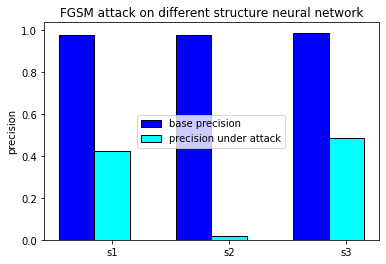

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
# width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars
bars1 = [np.mean(s1), np.mean(s2) , np.mean(s3)]
 
# Choose the height of the cyan bars
bars2 = [np.mean(s1_a), np.mean(s2_a) , np.mean(s3_a)]
 
# Choose the height of the error bars (bars1)
yer1 = [np.var(s1), np.var(s2), np.var(s3)]
 
# Choose the height of the error bars (bars2)
yer2 = [np.var(s1_a), np.var(s2_a), np.var(s3_a)]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1 ,capsize=7, label='base precision')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2 ,capsize=7, label='precision under attack')
 
# general layout
plt.title('FGSM attack on different structure neural network')
plt.xticks([r + barWidth for r in range(len(bars1))], ['s1', 's2', 's3'])
plt.ylabel('precision')
plt.legend()


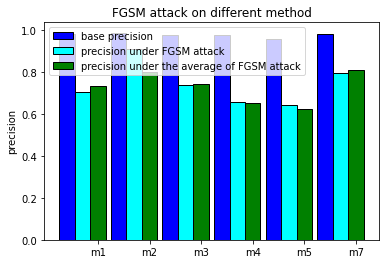

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
# width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars
bars1 = [np.mean(m1_base), np.mean(m2_base) , np.mean(m3_base), np.mean(m4_base), np.mean(m5_base), np.mean(m7_base)]
 
# Choose the height of the cyan bars
bars2 = [np.mean(m1_attack1), np.mean(m2_attack1) , np.mean(m3_attack1), np.mean(m4_attack1), np.mean(m5_attack1), np.mean(m7_attack1)]

bars3 = [np.mean(m1_attack_all), np.mean(m2_attack_all) , np.mean(m3_attack_all), np.mean(m4_attack_all), np.mean(m5_attack_all), np.mean(m7_attack_all)]

 
# Choose the height of the error bars (bars1)
yer1 = [np.var(s1), np.var(s2), np.var(s3)]
 
# Choose the height of the error bars (bars2)
yer2 = [np.var(s1_a), np.var(s2_a), np.var(s3_a)]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 =  [x + barWidth for x in r2]
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black' ,capsize=7, label='base precision')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black' ,capsize=7, label='precision under FGSM attack')
 
plt.bar(r3, bars3, width = barWidth, color = 'green', edgecolor = 'black' ,capsize=7, label='precision under the average of FGSM attack')
# general layout
plt.title('FGSM attack on different method')
plt.xticks([r + 2*barWidth for r in range(len(bars1))], ['m1', 'm2', 'm3','m4','m5','m7'])
plt.ylabel('precision')
plt.legend()

##Adv-GAN

In [ ]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-tylaiidd
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-tylaiidd
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=c188d0efac9cb270ea3f3cb355d3faeedca80609757305e50f0c6fc5b3ece731
  Stored in directory: /tmp/pip-ephem-wheel-cache-bi1h9f31/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.utils import to_categorical
from keras import layers, Model
from keras.layers import Input, Dense, Dropout, Flatten, Reshape, Activation, Lambda, LeakyReLU
from keras.layers import Conv2D, AveragePooling2D, Conv2DTranspose, BatchNormalization,MaxPooling2D
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.optimizers import Adam, SGD
from keras.metrics import binary_accuracy
from keras import backend as K
import os, cv2, re, random
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed
import tensorflow
#from tensorflow import set_random_seed

class DCGAN():

    def __init__(self):
        #input image dimensions
        self.img_width = 28
        self.img_height = 28
        self.input_shape = (self.img_width, self.img_height, 1) #1 channel for grayscale

        optimizer_g = Adam(0.0002)
        optimizer_d = SGD(0.01)

        inputs = Input(shape=self.input_shape)
        outputs = self.build_generator(inputs)
        self.G = Model(inputs, outputs)
        self.G.summary()

        outputs = self.build_discriminator(self.G(inputs))
        self.D = Model(inputs, outputs)
        self.D.compile(loss=keras.losses.binary_crossentropy, optimizer = optimizer_d, metrics=[self.custom_acc])
        self.D.summary()

        outputs = self.build_target(self.G(inputs))
        self.target = Model(inputs, outputs)
        self.target.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
        self.target.summary()

        self.stacked = Model(inputs=inputs, outputs=[self.G(inputs), self.D(self.G(inputs)), self.target(self.G(inputs))])
        self.stacked.compile(loss=[self.generator_loss, keras.losses.binary_crossentropy, keras.losses.binary_crossentropy], optimizer = optimizer_g)
        self.stacked.summary()

    def generator_loss(self, y_true, y_pred):
        return K.mean(K.maximum(K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1)) - 0.3, 0), axis=-1)
        #||G(x) - x||_2 - c, where c is user-defined. Here it is set to 0.3

    def custom_acc(self, y_true, y_pred):
        return binary_accuracy(K.round(y_true), K.round(y_pred))

    #build the cnn
    def build_discriminator(self, inputs):

        D = Conv2D(32, 4, strides=(2,2))(inputs)
        D = LeakyReLU()(D)
        D = Dropout(0.4)(D)
        D = Conv2D(64, 4, strides=(2,2))(D)
        D = BatchNormalization()(D)
        D = LeakyReLU()(D)
        D = Dropout(0.4)(D)
        D = Flatten()(D)
        D = Dense(64)(D)
        D = BatchNormalization()(D)
        D = LeakyReLU()(D)
        D = Dense(1, activation='sigmoid')(D)
        return D


    def build_generator(self, inputs):
        #c3s1-8
        G = Conv2D(8, 3, padding='same')(inputs)
        G = InstanceNormalization()(G)
        G = Activation('relu')(G)

        #d16
        G = Conv2D(16, 3, strides=(2,2), padding='same')(G)
        G = InstanceNormalization()(G)
        G = Activation('relu')(G)

        #d32
        G = Conv2D(32, 3, strides=(2,2), padding='same')(G)
        G = InstanceNormalization()(G)
        G = Activation('relu')(G)

        residual = G
        #four r32 blocks
        for _ in range(4):
            G = Conv2D(32, 3, padding='same')(G)
            G = BatchNormalization()(G)
            G = Activation('relu')(G)
            G = Conv2D(32, 3, padding='same')(G)
            G = BatchNormalization()(G)
            G = layers.add([G, residual])
            residual = G

        #u16
        G = Conv2DTranspose(16, 3, strides=(2,2), padding='same')(G)
        G = InstanceNormalization()(G)
        G = Activation('relu')(G)

        #u8
        G = Conv2DTranspose(8, 3, strides=(2,2), padding='same')(G)
        G = InstanceNormalization()(G)
        G = Activation('relu')(G)

        #c3s1-3
        G = Conv2D(1, 3, padding='same')(G)
        G = InstanceNormalization()(G)
        G = Activation('relu')(G)
        G = layers.add([G, inputs])

        return G

    def build_target(self, inputs):
        f = Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(inputs)
        f = Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(f)
        f = Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(f)
        f = MaxPooling2D(pool_size=(2, 2))(f)
        f = Dropout(0.2)(f)
        f = Flatten()(f)
        f = Dense(32)(f)
        f = Dropout(0.2)(f)
        f = Dense(32)(f)
        f = Dropout(0.2)(f)
        f = Dense(2, activation='softmax')(f)
        return f



    def get_batches(self, start, end, x_train, y_train):
        x_batch = x_train[start:end]
        Gx_batch = self.G.predict_on_batch(x_batch)
        y_batch = y_train[start:end]
        return x_batch, Gx_batch, y_batch


    def train_D_on_batch(self, batches):
        x_batch, Gx_batch, _ = batches

        #for each batch:
            #predict noise on generator: G(z) = batch of fake images
            #train fake images on discriminator: D(G(z)) = update D params per D's classification for fake images
            #train real images on disciminator: D(x) = update D params per classification for real images

        #Update D params
        self.D.trainable = True
        d_loss_real = self.D.train_on_batch(x_batch, np.random.uniform(0.9, 1.0, size=(len(x_batch), 1)) ) #real=1, positive label smoothing
        d_loss_fake = self.D.train_on_batch(Gx_batch, np.zeros((len(Gx_batch), 1)) ) #fake=0
        d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

        return d_loss #(loss, accuracy) tuple


    def train_stacked_on_batch(self, batches):
        x_batch, _, y_batch = batches
        flipped_y_batch = 1.-y_batch

        #for each batch:
            #train fake images on discriminator: D(G(z)) = update G params per D's classification for fake images

        #Update only G params
        self.D.trainable = False
        self.target.trainable = False
        stacked_loss = self.stacked.train_on_batch(x_batch, [x_batch, np.ones((len(x_batch), 1)), to_categorical(flipped_y_batch)] )
        #stacked_loss = self.stacked.train_on_batch(x_batch, [x_batch, np.ones((len(x_batch), 1)), to_categorical(y_batch)] )
        #input to full GAN is original image
        #output 1 label for generated image is original image
        #output 2 label for discriminator classification is real/fake; G wants D to mark these as real=1
        #output 3 label for target classification is 1/3; g wants to flip these so 1=1 and 3=0
        return stacked_loss #(total loss, hinge loss, gan loss, adv loss) tuple


    def train_GAN(self):
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        x_train = (x_train *2./255 - 1).reshape((len(x_train), 28, 28, 1)) #pixel values in range [-1., 1.] for D
        binary_indices = np.where(y_train == 1)
        x_ones = x_train[binary_indices][:6000]
        y_ones = np.zeros((6000, 1))
        binary_indices = np.where(y_train == 3)
        x_threes = x_train[binary_indices][:6000]
        y_threes = np.ones((6000, 1))
        x_train = np.concatenate((x_ones, x_threes)) #(12000, 28, 28, 1)
        y_train = np.concatenate((y_ones, y_threes)) #1=0, 3=1
        zipped = list(zip(x_train,y_train))
        np.random.shuffle(zipped)
        x_train, y_train = zip(*zipped)
        x_train = np.array(x_train)
        y_train = np.array(y_train)

        self.target.fit(x_train, to_categorical(y_train), epochs=5) #pretrain target

        epochs = 5
        batch_size = 128
        num_batches = len(x_train)//batch_size
        if len(x_train) % batch_size != 0:
            num_batches += 1

        for epoch in range(epochs)[::-1]:
            print("Epoch " + str(epoch))
            batch_index = 0

            for batch in range(num_batches - 1):
                start = batch_size*batch_index
                end = batch_size*(batch_index+1)
                batches = self.get_batches(start, end, x_train, y_train)
                self.train_D_on_batch(batches)
                self.train_stacked_on_batch(batches)
                batch_index += 1


            start = batch_size*batch_index
            end = len(x_train)
            x_batch, Gx_batch, y_batch = self.get_batches(start, end, x_train, y_train)

            (d_loss, d_acc) = self.train_D_on_batch((x_batch, Gx_batch, y_batch))
            (g_loss, hinge_loss, gan_loss, adv_loss) = self.train_stacked_on_batch((x_batch, Gx_batch, y_batch))

            target_acc = self.target.test_on_batch(Gx_batch, to_categorical(y_batch))[1]
            target_predictions = self.target.predict_on_batch(Gx_batch) #(96,2)

            misclassified = np.where(y_batch.reshape((len(x_train) % batch_size, )) != np.argmax(target_predictions, axis=1))[0]
            print(np.array(misclassified).shape)
            print(misclassified)

            print("Discriminator -- Loss:%f\tAccuracy:%.2f%%\nGenerator -- Loss:%f\nHinge Loss: %f\nTarget Loss: %f\tAccuracy:%.2f%%" %(d_loss, d_acc*100., gan_loss, hinge_loss, adv_loss, target_acc*100.))

            if epoch == 0:
                self.res=(Gx_batch, y_batch)
                #self.save_generated_images("orig", Gx_batch, 'images')
            #if epoch % 5 == 0:
            #    self.save_generated_images(str(epoch), Gx_batch, 'images')
            #    self.save_generated_images(str(epoch), Gx_batch[misclassified], 'misclass')


    def save_generated_images(self, filename, batch, dir):
        batch = batch.reshape(batch.shape[0], self.img_width, self.img_height)
        rows, columns = 5, 5
        #self.res = batch
        fig, axs = plt.subplots(rows, columns)
        cnt = 0
        for i in range(rows):
            for j in range(columns):
                axs[i,j].imshow((batch[cnt] + 1)/2., interpolation='nearest', cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("%s/%s.png" % (dir, filename))
        plt.show()
        plt.close()



temp = None
if __name__ == '__main__':
    seed(5)
    tensorflow.random.set_seed(1)
    dcgan = DCGAN()
    dcgan.train_GAN()
    temp = dcgan.res

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 28, 28, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 28, 28, 8)    2           conv2d_62[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 8)    0           instance_normalization[0][0]     
_______________________________________________________________________________________

In [ ]:
[X1_GAN,Y_GAN]=temp
X_GAN = X1_GAN / 255

for i in range(len(X_GAN)):
  X_GAN[i] = X_GAN[i].reshape((-1, img_rows, img_cols, channels))
  if(Y_GAN[i]<0.5):
    Y_GAN[i]=1
  else:
    Y_GAN[i]=3
Y_GAN = tf.keras.utils.to_categorical(Y_GAN, num_classes)

In [ ]:
S1_GAN=model1.evaluate(x=X_GAN, y=Y_GAN, verbose=0)[1]
print("Base accuracy on regular images with ADV-GAN attack", S1_GAN) 

Base accuracy on regular images with ADV-GAN attack 0.5208333134651184


In [ ]:
S2_GAN=model2.evaluate(x=X_GAN, y=Y_GAN, verbose=0)[1]
print("Base accuracy on regular images with ADV-GAN attack", S2_GAN) 

Base accuracy on regular images with ADV-GAN attack 0.0


In [ ]:
S3_GAN=model3.evaluate(x=X_GAN, y=Y_GAN, verbose=0)[1]
print("precision with ADV-GAN attack from one neural network:", S3_GAN) 

precision with ADV-GAN attack from one neural network: 0.4791666567325592


In [ ]:
M1_GAN=evaluate_n_members(ensemble_same_struct,3,X_GAN,Y_GAN)
print("precision with ADV-GAN attack:",M1_GAN)

precision with ADV-GAN attack: 0.4791666666666667


In [ ]:
M2_GAN=evaluate_n_members(ensemble_diff_structs,3,X_GAN,Y_GAN)
print("precision with ADV-GAN attack:",M2_GAN)

precision with ADV-GAN attack: 0.4791666666666667


In [ ]:
M3_GAN=evaluate_n_members(ensemble_same_struct_random_split,3,X_GAN,Y_GAN)
print("precision with average gradient attack from all neural network:",M3_GAN)

precision with average gradient attack from all neural network: 0.4791666666666667


In [ ]:
M4_GAN=evaluate_n_members(ensemble_same_struct_k_fold,3,X_GAN,Y_GAN)
print("precision with average gradient attack from all neural network:",M4_GAN)

precision with average gradient attack from all neural network: 0.4791666666666667


In [ ]:
M5_GAN=evaluate_n_members(ensemble_same_struct_bagging,3,X_GAN,Y_GAN)
print("precision with average gradient attack from all neural network:",M5_GAN)

precision with average gradient attack from all neural network: 0.4791666666666667


In [ ]:
M7_GAN=evaluate_n_members(M7,3,X_GAN,Y_GAN)
print("precision with average gradient attack from all neural network:",M7_GAN)

precision with average gradient attack from all neural network: 0.4791666666666667


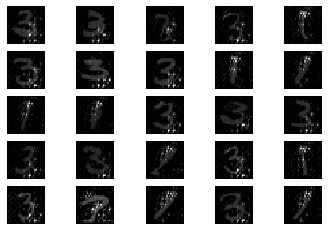

In [ ]:
#Plot attack sample images
dcgan.save_generated_images("",X1_GAN,"")

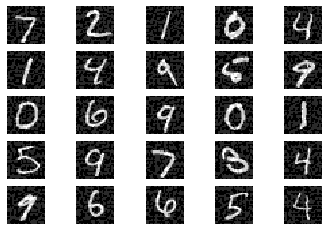

In [ ]:
dcgan.save_generated_images("",ad_attack1,"")

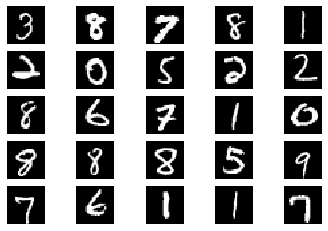

In [ ]:
dcgan.save_generated_images("",trainX,"")

#Comparison between base precision and precision after attack

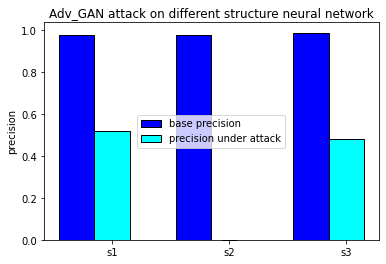

In [ ]:
# width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars
bars1 = [np.mean(s1), np.mean(s2) , np.mean(s3)]
 
# Choose the height of the cyan bars
bars2 = [S1_GAN, S2_GAN , S3_GAN]
 
# Choose the height of the error bars (bars1)
yer1 = [np.var(s1), np.var(s2), np.var(s3)]
 
# Choose the height of the error bars (bars2)
yer2 = [np.var(s1_a), np.var(s2_a), np.var(s3_a)]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1 ,capsize=7, label='base precision')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2 ,capsize=7, label='precision under attack')
 
# general layout
plt.title('Adv_GAN attack on different structure neural network')
plt.xticks([r + barWidth for r in range(len(bars1))], ['s1', 's2', 's3'])
plt.ylabel('precision')
plt.legend()


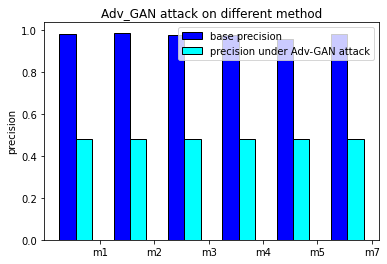

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
# width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars
bars1 = [np.mean(m1_base), np.mean(m2_base) , np.mean(m3_base), np.mean(m4_base), np.mean(m5_base), np.mean(m7_base)]
 
# Choose the height of the cyan bars
bars2 = [M1_GAN, M2_GAN , M3_GAN, M4_GAN, M5_GAN, M7_GAN]

#bars3 = [np.mean(m1_attack_all), np.mean(m2_attack_all) , np.mean(m3_attack_all), np.mean(m4_attack_all), np.mean(m5_attack_all), np.mean(m7_attack_all)]

 
# Choose the height of the error bars (bars1)
#yer1 = [np.var(s1), np.var(s2), np.var(s3)]
 
# Choose the height of the error bars (bars2)
#yer2 = [np.var(s1_a), np.var(s2_a), np.var(s3_a)]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
#r3 =  [x + barWidth for x in r2]
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black' ,capsize=7, label='base precision')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black' ,capsize=7, label='precision under Adv-GAN attack')
 
#plt.bar(r3, bars3, width = barWidth, color = 'green', edgecolor = 'black' ,capsize=7, label='precision under the average of FGSM attack')
# general layout
plt.title('Adv_GAN attack on different method')
plt.xticks([r + 2*barWidth for r in range(len(bars1))], ['m1', 'm2', 'm3','m4','m5','m7'])
plt.ylabel('precision')
plt.legend()

In [ ]:
import tensorflow
print(tensorflow.__version__)


2.3.0
